In [1]:
suppressPackageStartupMessages({
    library(tidyverse);
    library(stringr);
    library(magrittr);
    library(modelr);
    library(broom);
    library(purrr)
})

source("../code/utils.R")

### Load the EMH data

**FIXME** here's another instance of the "chromosome 9" is removed bug

In [2]:
ice_age <- read_tsv("../data/genotypes/ice_age.tsv", progress=FALSE) %>%
    random_call(c("Loschbour", "Stuttgart", "UstIshim")) %>%
    mutate(subst=paste0(ref, "-", alt))
ice_age[ice_age == 9] <- NA

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.


### Load the modern data

**FIXME** and yet another example of the same bug

In [3]:
sgdp <- read_tsv("../data/genotypes/sgdp.tsv", progress=FALSE) %>%
    select(chrom, pos, ref, alt, S_French_1, S_French_2, S_Sardinian_1, S_Sardinian_2, S_Han_1, S_Han_2) %>% 
    random_call %>%
    mutate(subst=paste0(ref, "-", alt))
names(sgdp)[-(1 : 4)] %<>% str_replace("^S_", "SGDP_")
sgdp[sgdp == 9] <- NA

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.


### Summarise the substitution rates for each sample

In [4]:
samples_long <- right_join(ice_age, sgdp) %>%
    select(-c(chrom, pos, ref, alt)) %>%
    gather(sample, snp, -subst) %>% 
    mutate(age=ifelse(str_detect(sample, "^SGDP_"), "modern", "ancient"))

Joining, by = c("chrom", "pos", "ref", "alt", "subst")


In [5]:
subst_rates <-  samples_long %>%
    filter(snp == 2) %>%  # filter for SNPs
    group_by(sample) %>%  mutate(total=n()) %>% # calculate the total number of SNPs per sample
    ungroup %>%
    group_by(sample, subst, total, age) %>% summarise(count=n()) %>% # calculate different substitutions for each sample
    mutate(prop=count / total)  %>% # calculate the proportion
    ungroup

In [6]:
head(subst_rates)

sample,subst,total,age,count,prop
AfontovaGora2,A-C,711,ancient,23,0.03234880
AfontovaGora2,A-G,711,ancient,108,0.15189873
AfontovaGora2,A-T,711,ancient,16,0.02250352
AfontovaGora2,C-A,711,ancient,26,0.03656821
AfontovaGora2,C-G,711,ancient,37,0.05203938
AfontovaGora2,C-T,711,ancient,137,0.19268636


### Counts of SNPs for each sample

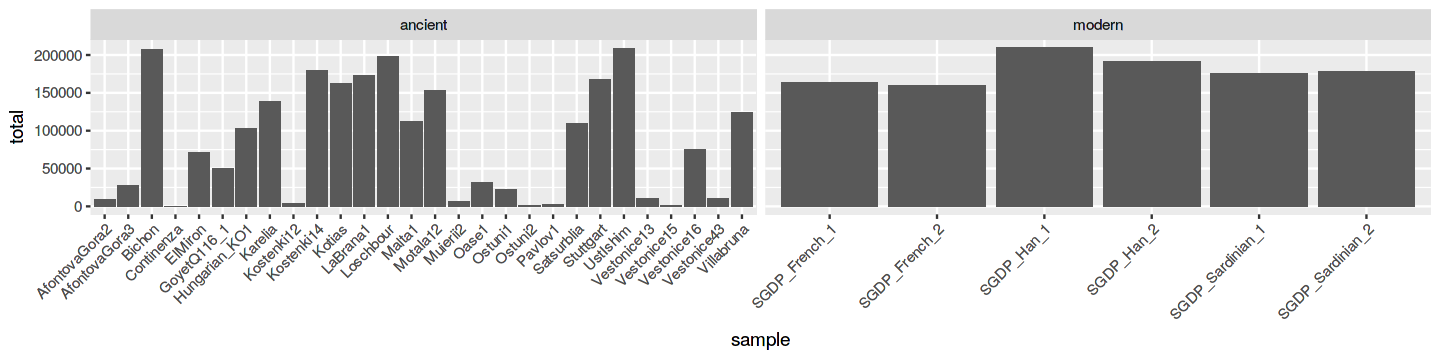

In [7]:
options(repr.plot.width=12, repr.plot.height=3)

ggplot(subst_rates, aes(sample, total)) +
    geom_bar(stat="identity") +
    facet_grid(. ~ age, scales="free_x") +
    theme(axis.text.x=element_text(angle=45, hjust=1))

### Proportions of substitutions in each sample

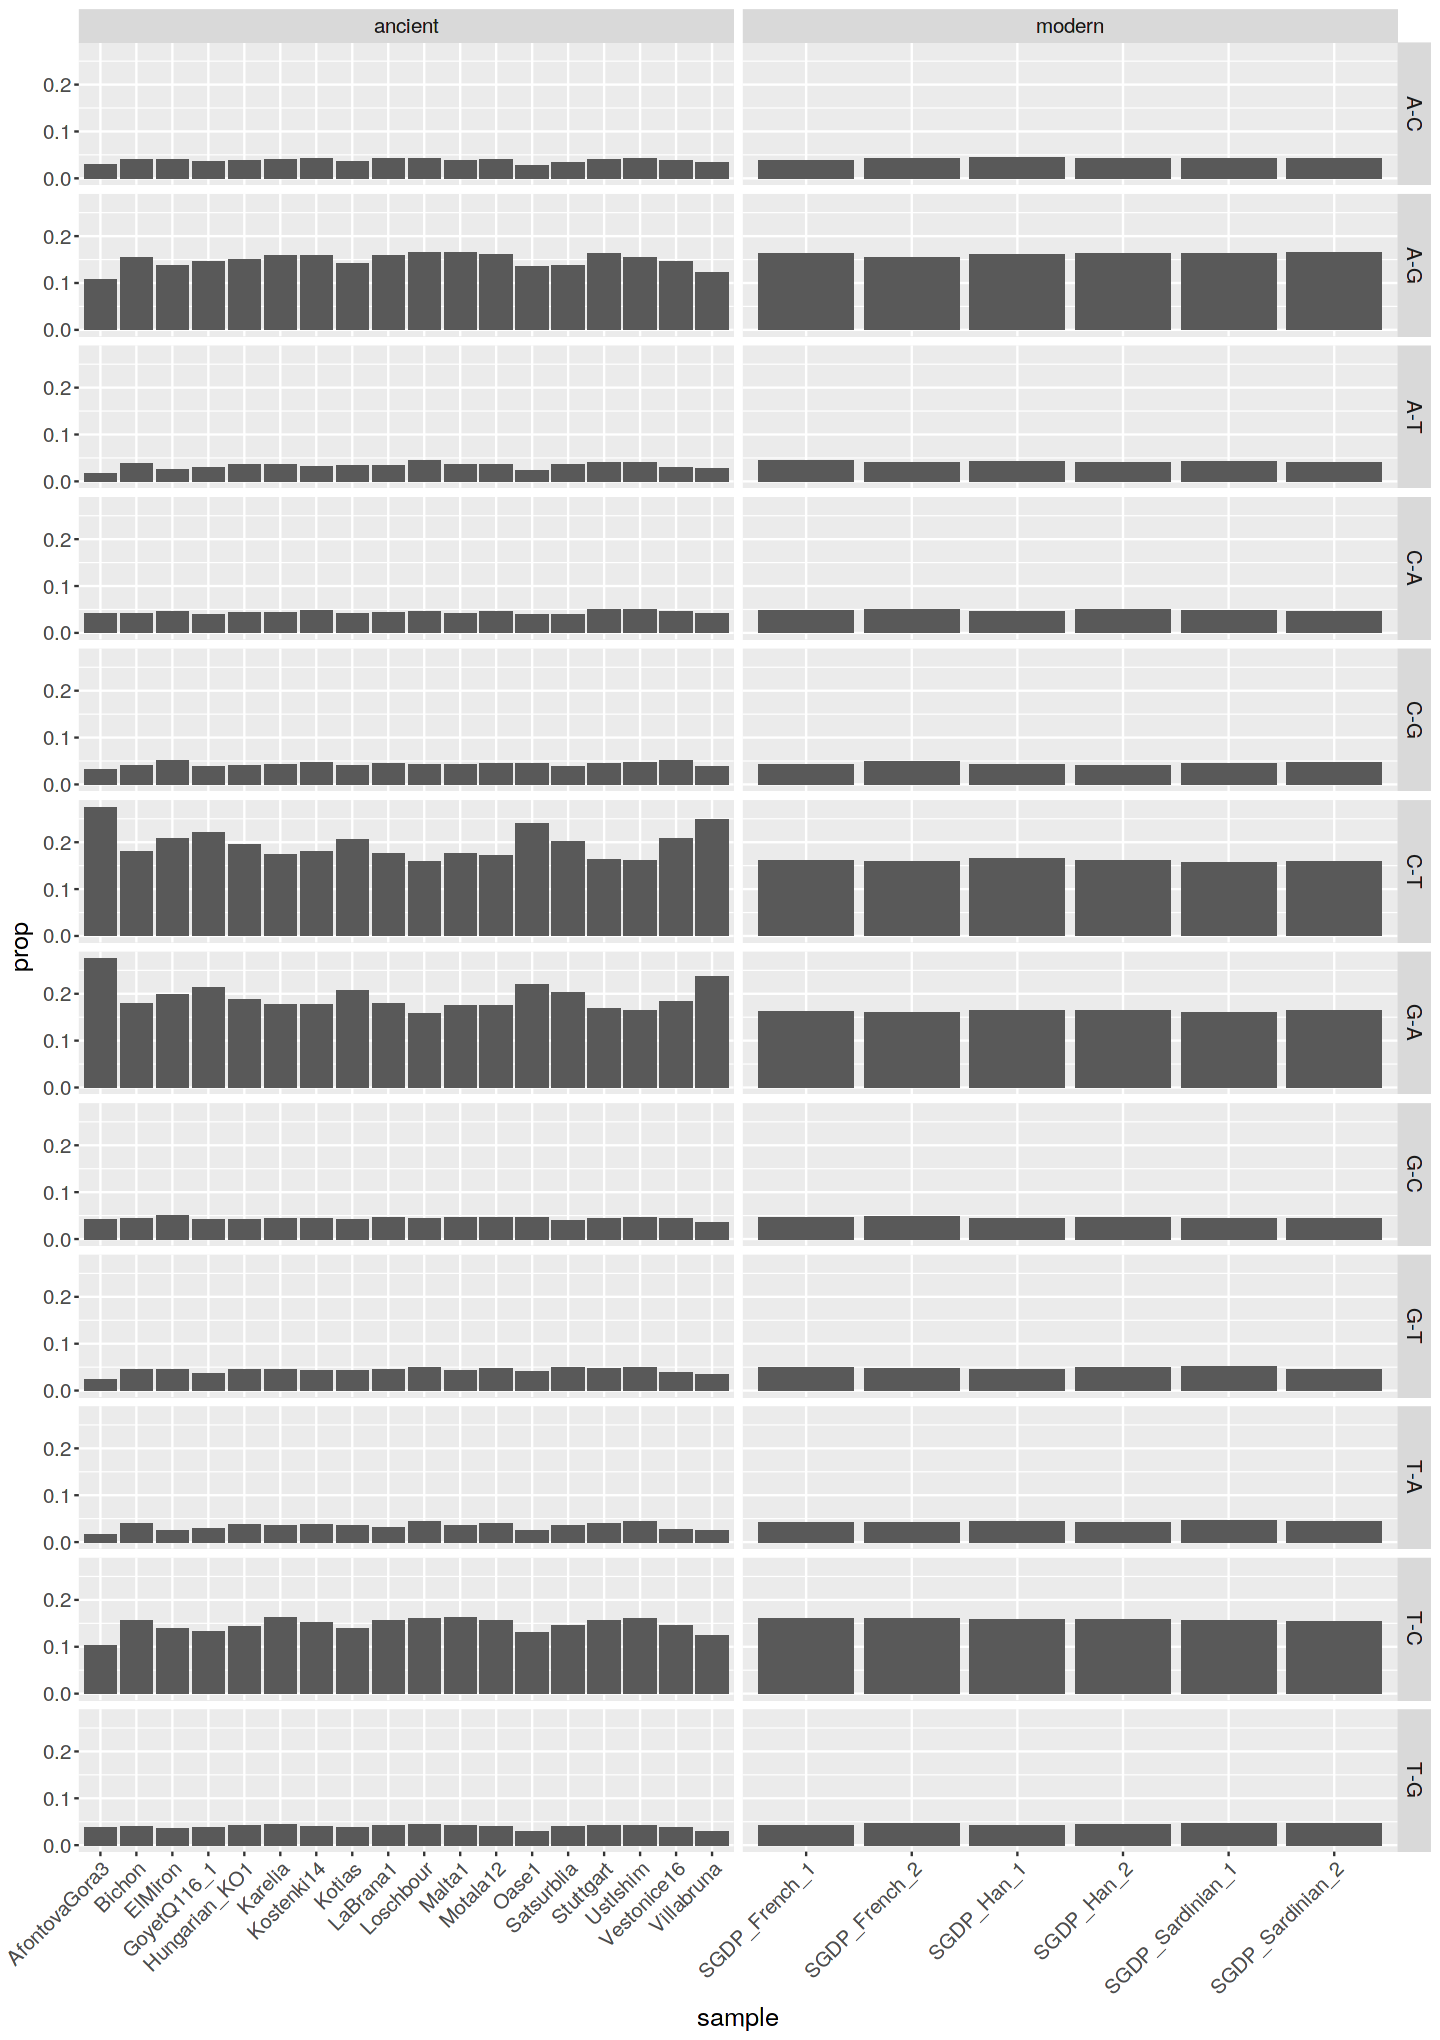

In [8]:
options(repr.plot.width=12, repr.plot.height=17)

subst_rates %>%
filter(total > 2000) %>%
    ggplot(aes(sample, prop, group=subst)) +
        geom_bar(stat="identity", position=position_dodge()) +
        facet_grid(subst ~ age, scales="free_x") +
        theme(text=element_text(size=15), axis.text.x=element_text(angle=45, hjust=1))

<font color="red">Add confidence intervals here</font>

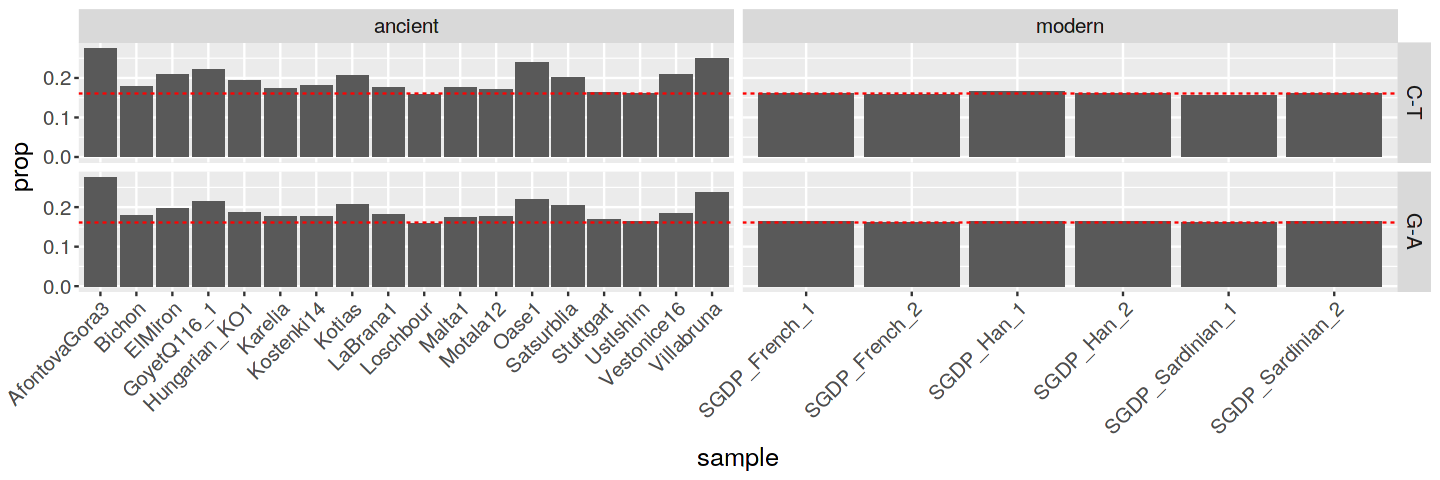

In [9]:
# SMBE
options(repr.plot.width=12, repr.plot.height=4)

avg_prop <- filter(subst_rates, subst %in% c("C-T", "G-A"), sample == "SGDP_French_1") %>% summarise(mean(prop)) %>% .[["mean(prop)"]]

subst_rates %>%
filter(subst %in% c("C-T", "G-A"), total > 2000) %>%
    ggplot(aes(sample, prop, group=subst)) +
        geom_bar(stat="identity", position=position_dodge()) +
        geom_hline(yintercept=avg_prop, color="red", linetype=2) +
        facet_grid(subst ~ age, scales="free_x") +
        theme(text=element_text(size=15), axis.text.x=element_text(angle=45, hjust=1))

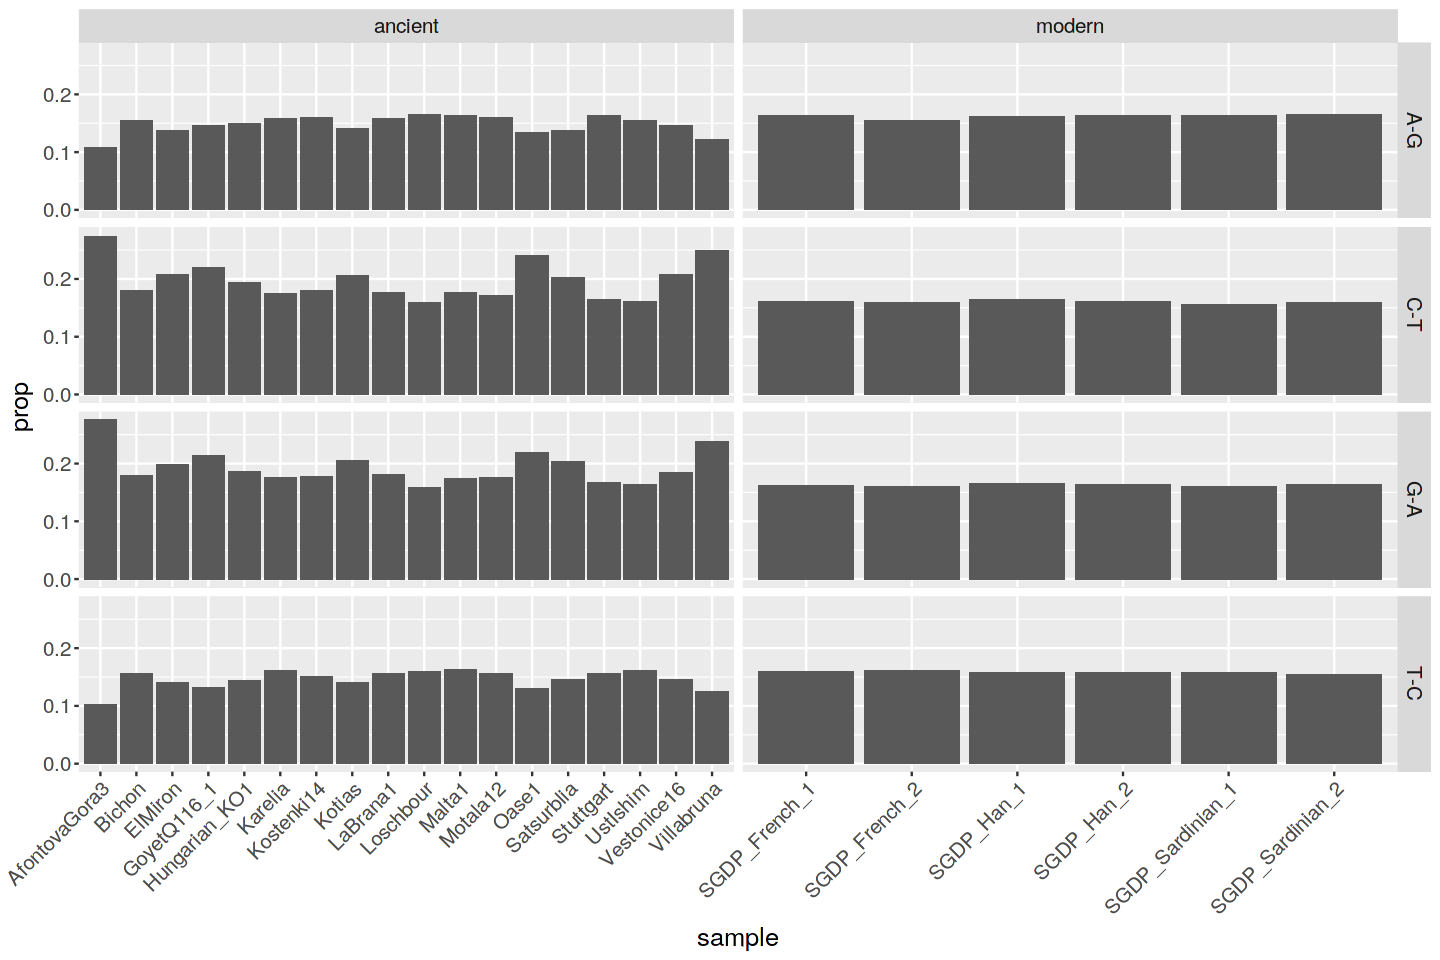

In [11]:
options(repr.plot.width=12, repr.plot.height=8)

subst_rates %>%
filter(subst %in% c("C-T", "G-A", "T-C", "A-G"), total > 2000) %>%
    ggplot(aes(sample, prop, group=subst)) +
        geom_bar(stat="identity", position=position_dodge()) +
        facet_grid(subst ~ age, scales="free_x") +
        theme(text=element_text(size=15), axis.text.x=element_text(angle=45, hjust=1))

We can clearly see which samples have not been treated with UDG or which have a different library preparation.

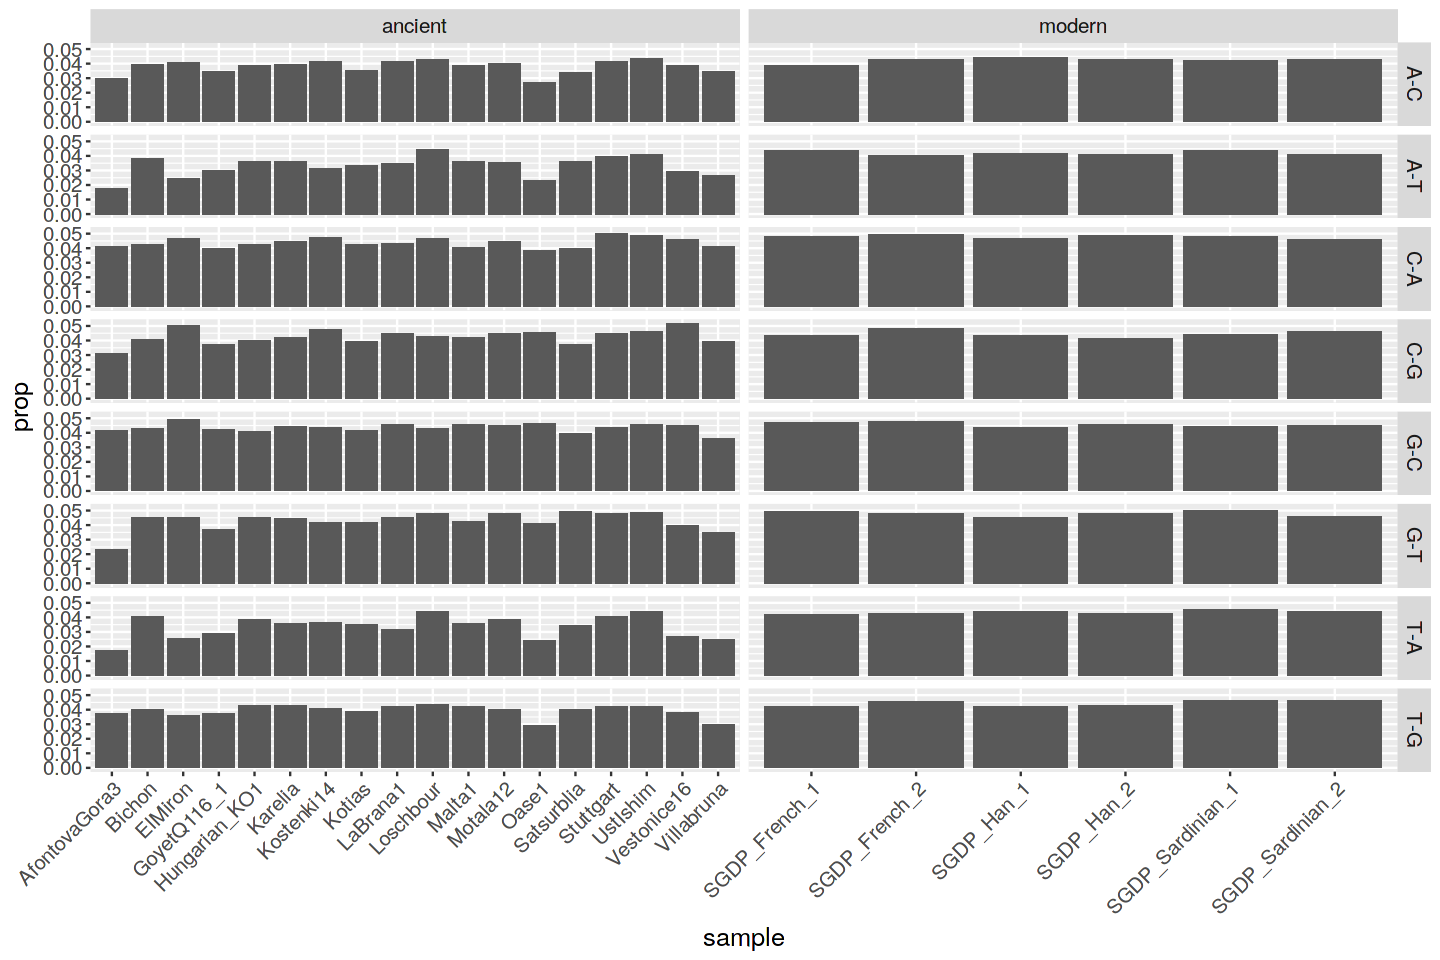

In [12]:
options(repr.plot.width=12, repr.plot.height=8)

subst_rates %>%
filter(! subst %in% c("C-T", "G-A", "T-C", "A-G"), total > 2000) %>%
    ggplot(aes(sample, prop, group=subst)) +
        geom_bar(stat="identity", position=position_dodge()) +
        facet_grid(subst ~ age, scales="free_x") +
        theme(text=element_text(size=15), axis.text.x=element_text(angle=45, hjust=1))

# How does all this affect the Neanderthal ancestry estimates?

In [13]:
suppressPackageStartupMessages({
    library(tidyverse);
    library(stringr);
    library(magrittr);
    library(modelr);
    library(broom);
    library(purrr)
})

source("../code/utils.R")

In [14]:
merged <- load_dataset("../data/genotypes/ice_age.tsv",
                       "../data/genotypes/sgdp.tsv",
                       "../data/genotypes/archaics.tsv",
                       filter_damage=FALSE)

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character(),
  Altai = col_integer(),
  Vindija = col_integer(),
  Denisovan = col_integer()
)
Joining, by = c("chrom", "pos", "ref", "alt")
Joining, by = c("chrom", "pos", "ref", "alt")


In [15]:
sgdp_info <-
  load_sgdp_info("../data/10_24_2014_SGDP_metainformation_update.txt") %>%
  filter(name %in% colnames(merged)) %>%
  mutate(age=0) %>%
  rename(pop=Region) %>%
  filter(pop == "WestEurasia") %>%
  filter(! Country %in% c('Iran', 'Iraq', 'Jordan', 'Israel(Central)',
                          'Israel(Carmel)', 'Israel(Negev)', 'Israel', 'Tajikistan', 'Turkey', 'Yemen',
                          'Abkhazia', 'Armenia'))

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”Parsed with column specification:
cols(
  .default = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  Coverage = col_integer(),
  HetRateAuto = col_double()
)
See spec(...) for full column specifications.


In [16]:
ages <-
  read_delim("../data/emh_ages.txt", delim=" ", col_names=c("name", "age")) %>%
  bind_rows(tibble(name=sgdp_info$name,
                   age=rep(0L, nrow(sgdp_info)))) %>%
  mutate(post_admixture=as.integer(55000 - age))

sample_names <- colnames(merged)[colnames(merged) %in% ages$name]

Parsed with column specification:
cols(
  name = col_character(),
  age = col_integer()
)


In [17]:
# calculate Nea. ancestry using all sites
nea_ancestry_all <-
  tibble(
      name=sample_names, 
      nea=estimate_nea(merged, sample_names),
      missing=sapply(sample_names, function(s) { mean(is.na(merged[[s]])) }),
      snp_count=sapply(sample_names, function(s) { sum(!is.na(merged[[s]])) })
  ) %>%
  inner_join(ages, by="name") %>%
  arrange(post_admixture) %>%
  mutate(set="all_sites")

# calculate Nea. ancestry after removing transitions
tv_only <- remove_transitions(merged)
nea_ancestry_tv <-
  tibble(
      name=sample_names, 
      nea=estimate_nea(tv_only, sample_names),
      missing=sapply(sample_names, function(s) { mean(is.na(merged[[s]])) }),
      snp_count=sapply(sample_names, function(s) { sum(!is.na(merged[[s]])) })
  ) %>%
  inner_join(ages, by="name") %>%
  arrange(post_admixture) %>%
  mutate(set="removed_transitions")


#
# Remove SNPs that could be enriched for aDNA errors.
#
remove_ct_ga <- function(snps) {
    filter(snps, !(
        (ref == "C" & alt == "T") |
        (ref == "G" & alt == "A")

    ))
}

# calculate Nea. ancestry after removing C->T and G->A substitutions
ct_ga_only <- remove_ct_ga(merged)
nea_ancestry_ct_ga <-
  tibble(
      name=sample_names, 
      nea=estimate_nea(ct_ga_only, sample_names),
      missing=sapply(sample_names, function(s) { mean(is.na(merged[[s]])) }),
      snp_count=sapply(sample_names, function(s) { sum(!is.na(merged[[s]])) })
  ) %>%
  inner_join(ages, by="name") %>%
  arrange(post_admixture) %>%
  mutate(set="removed_ct_and_ga")

nea_ancestry <- bind_rows(nea_ancestry_all, nea_ancestry_tv, nea_ancestry_ct_ga)

Showing the Oase1 Nea% with/without filtering might be a good example of why the filtering is crucial, and how screwed up the Ice Age data set is...

In [18]:
# removing C-T, G-A, T-C, A-G substitutions
filter(nea_ancestry, name == "Oase1")

name,nea,missing,snp_count,age,post_admixture,set
Oase1,0.07386707,0.921265,38109,39610,15390,all_sites
Oase1,0.05881378,0.921265,38109,39610,15390,removed_transitions
Oase1,0.06451907,0.921265,38109,39610,15390,removed_ct_and_ga


### Plot the rates of missing data

In [19]:
missing_cutoff <- 0.98

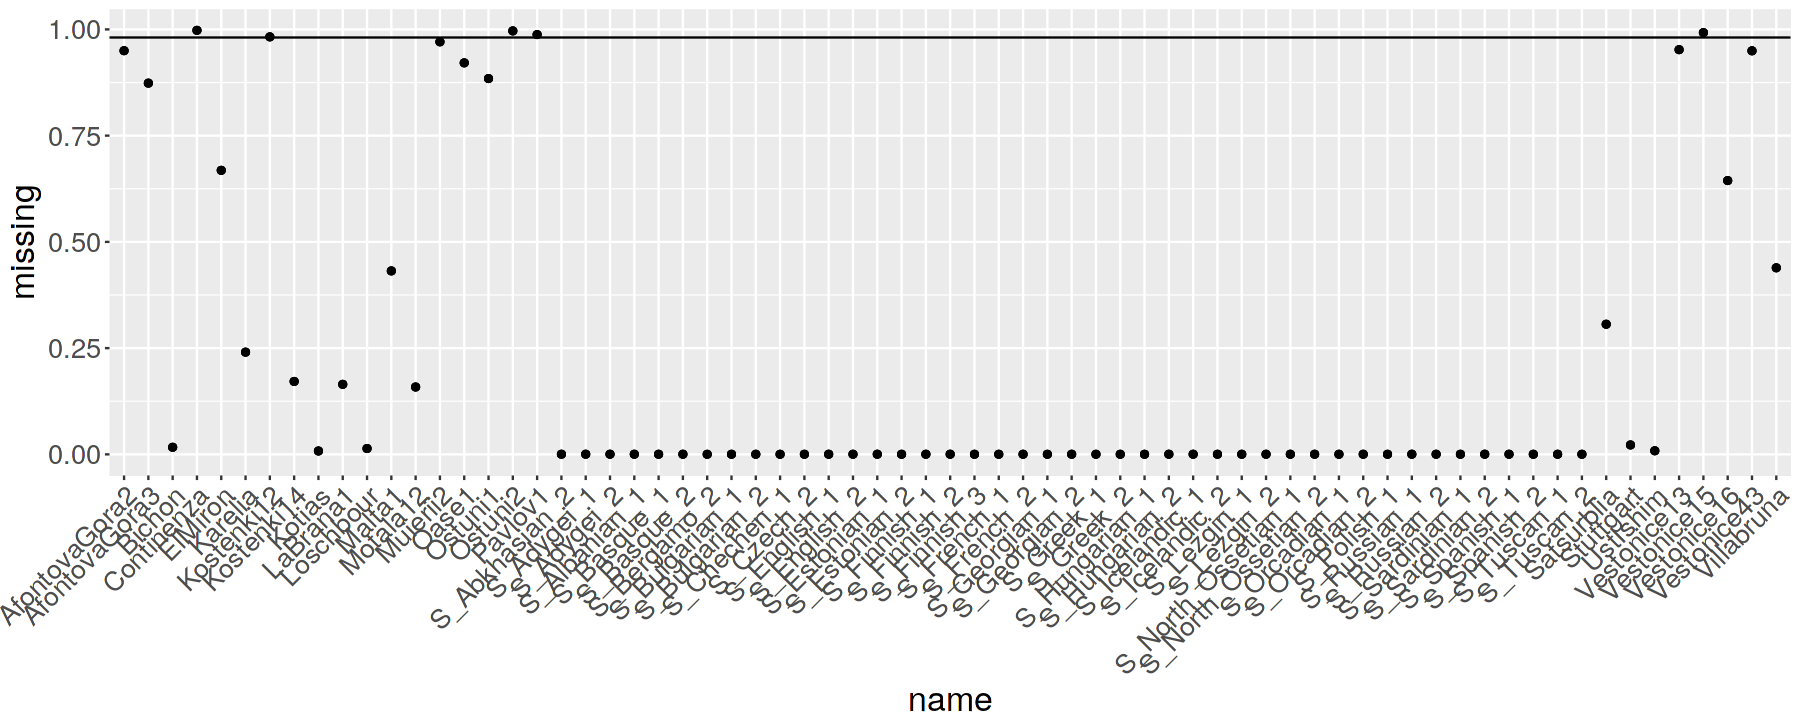

In [20]:
options(repr.plot.width=15, repr.plot.height=6)

nea_ancestry %>%
group_by(name, missing) %>%
ggplot(aes(name, missing)) +
    geom_point()+
    theme(text=element_text(size=20), axis.text.x=element_text(angle=45, hjust=1)) +
    geom_hline(yintercept=missing_cutoff)

### Plot the differences in Nea. estimates for filtered and all sites

In [21]:
diffs <- nea_ancestry %>%
  group_by(name) %>%
  spread(set, nea) %>%
  mutate(difference=abs(all_sites - removed_transitions))
diffs$name <- factor(diffs$name, levels=diffs$name[order(diffs$difference)])

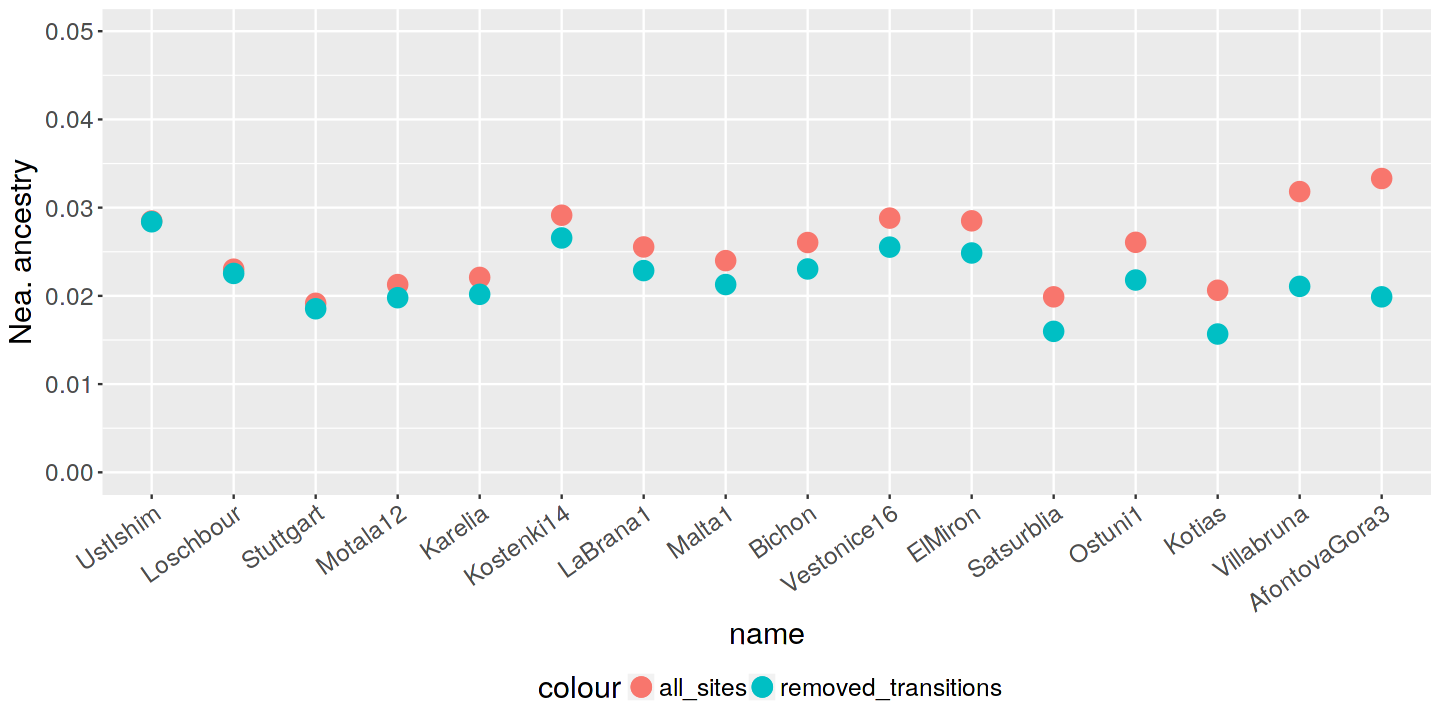

In [22]:
# SMBE
options(repr.plot.width=12, repr.plot.height=6)

filter(diffs, snp_count > 50000) %>% filter(!str_detect(name, "^S_")) %>% 
ggplot() +
  geom_point(aes(name, all_sites, color="all_sites"), size=5) +
  geom_point(aes(name, removed_transitions, color="removed_transitions"), size=5) +
#  geom_point(aes(name, removed_ct_and_ga, color="removed_ct_and_ga"), size=5) +
  ylim(0, 0.05) + ylab("Nea. ancestry") +
  theme(legend.position="bottom", text=element_text(size=18), axis.text.x=element_text(angle=35, hjust=1)) 

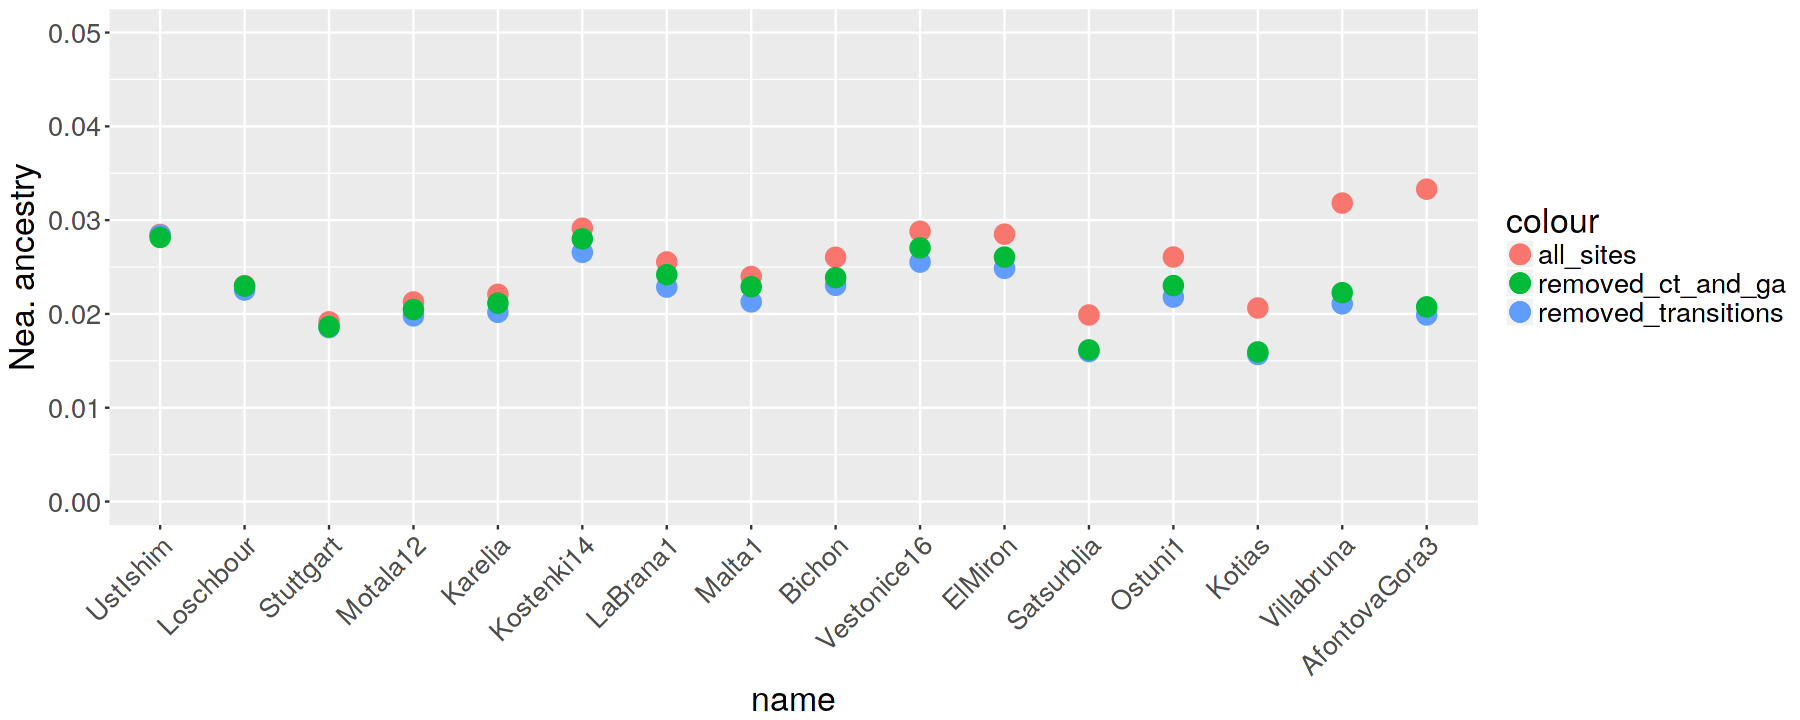

In [23]:
options(repr.plot.width=15, repr.plot.height=6)

filter(diffs, snp_count > 40000) %>% filter(!str_detect(name, "^S_")) %>% 
ggplot() +
  geom_point(aes(name, all_sites, color="all_sites"), size=5) +
  geom_point(aes(name, removed_transitions, color="removed_transitions"), size=5) +
  geom_point(aes(name, removed_ct_and_ga, color="removed_ct_and_ga"), size=5) +
  ylim(0, 0.05) + ylab("Nea. ancestry") +
  theme(text=element_text(size=20), axis.text.x=element_text(angle=45, hjust=1)) 

Warning message:
“Removed 2 rows containing missing values (geom_point).”

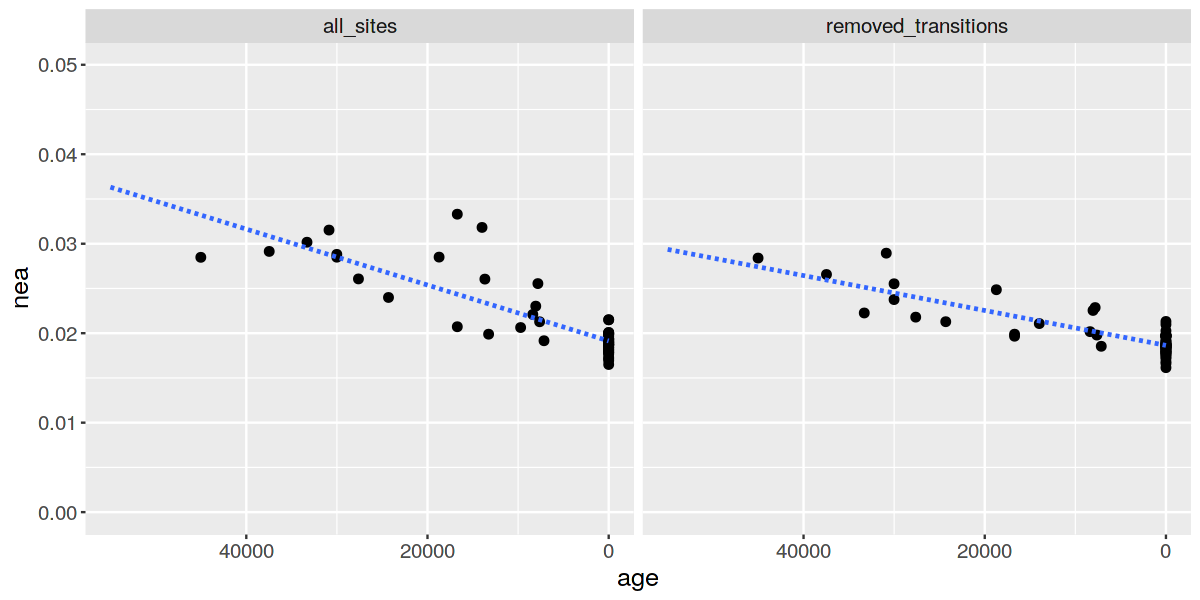

In [24]:
options(repr.plot.width=10, repr.plot.height=5)

filter(nea_ancestry,
       missing < missing_cutoff,
       (set == "all_sites" | !name %in% c("Satsurblia", "Kotias", "Bichon")),
       set != "removed_ct_and_ga") %>%
{ ggplot(.) +
  geom_point(aes(age, nea), size=2) +
  lims(y=c(0, 0.05), x=c(55000, 0)) +
  geom_smooth(aes(age, nea), method="lm", fullrange=TRUE, se=FALSE, linetype=2, data=filter(., name != "Oase1")) +
  facet_grid(. ~ set) +
  theme(text=element_text(size=15)) }

Warning message:
“Removed 1 rows containing missing values (geom_point).”

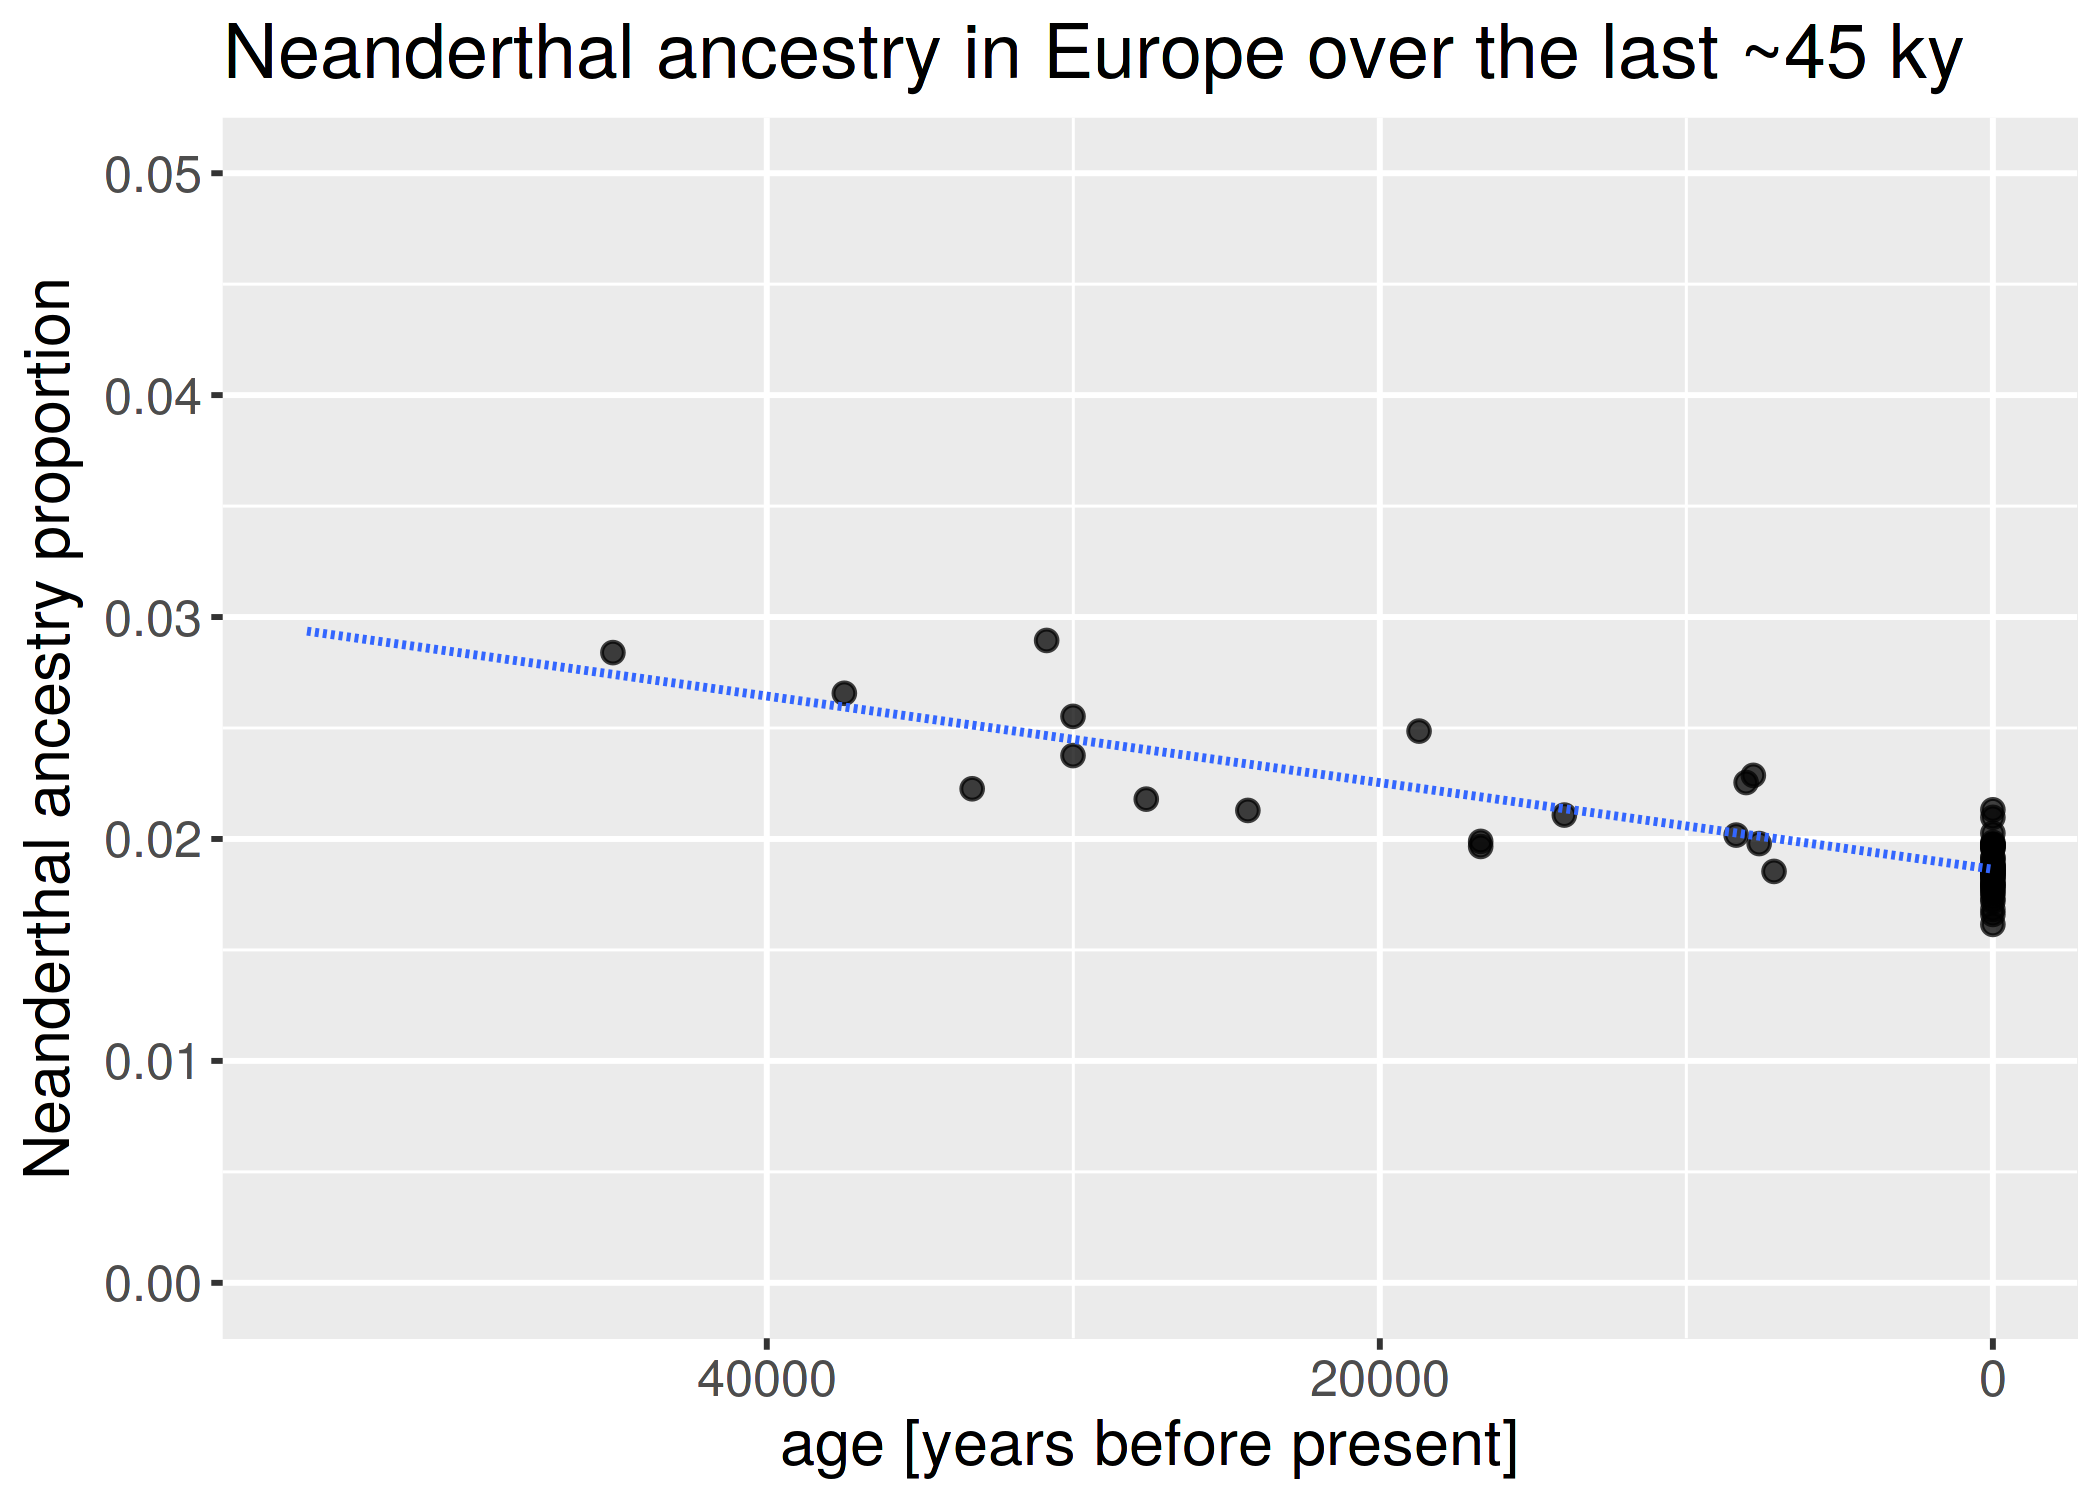

In [42]:
# SMBE
options(repr.plot.width=7, repr.plot.height=5, repr.plot.res=300)

filter(nea_ancestry,
       snp_count >= 10000,
       (set == "all_sites" | !name %in% c("Satsurblia", "Kotias", "Bichon")),
       set == "removed_transitions") %>%
{ ggplot(.) +
  geom_point(aes(age, nea), size=2, alpha=0.75) +
  lims(y=c(0, 0.05), x=c(55000, 0)) +
  geom_smooth(aes(age, nea), method="lm", fullrange=TRUE, se=FALSE, linetype=2,
              size=0.75, data=filter(., name != "Oase1")) +
  labs(y="Neanderthal ancestry proportion", x="age [years before present]",
       title="Neanderthal ancestry in Europe over the last ~45 ky") +
  theme(text=element_text(size=15)) }

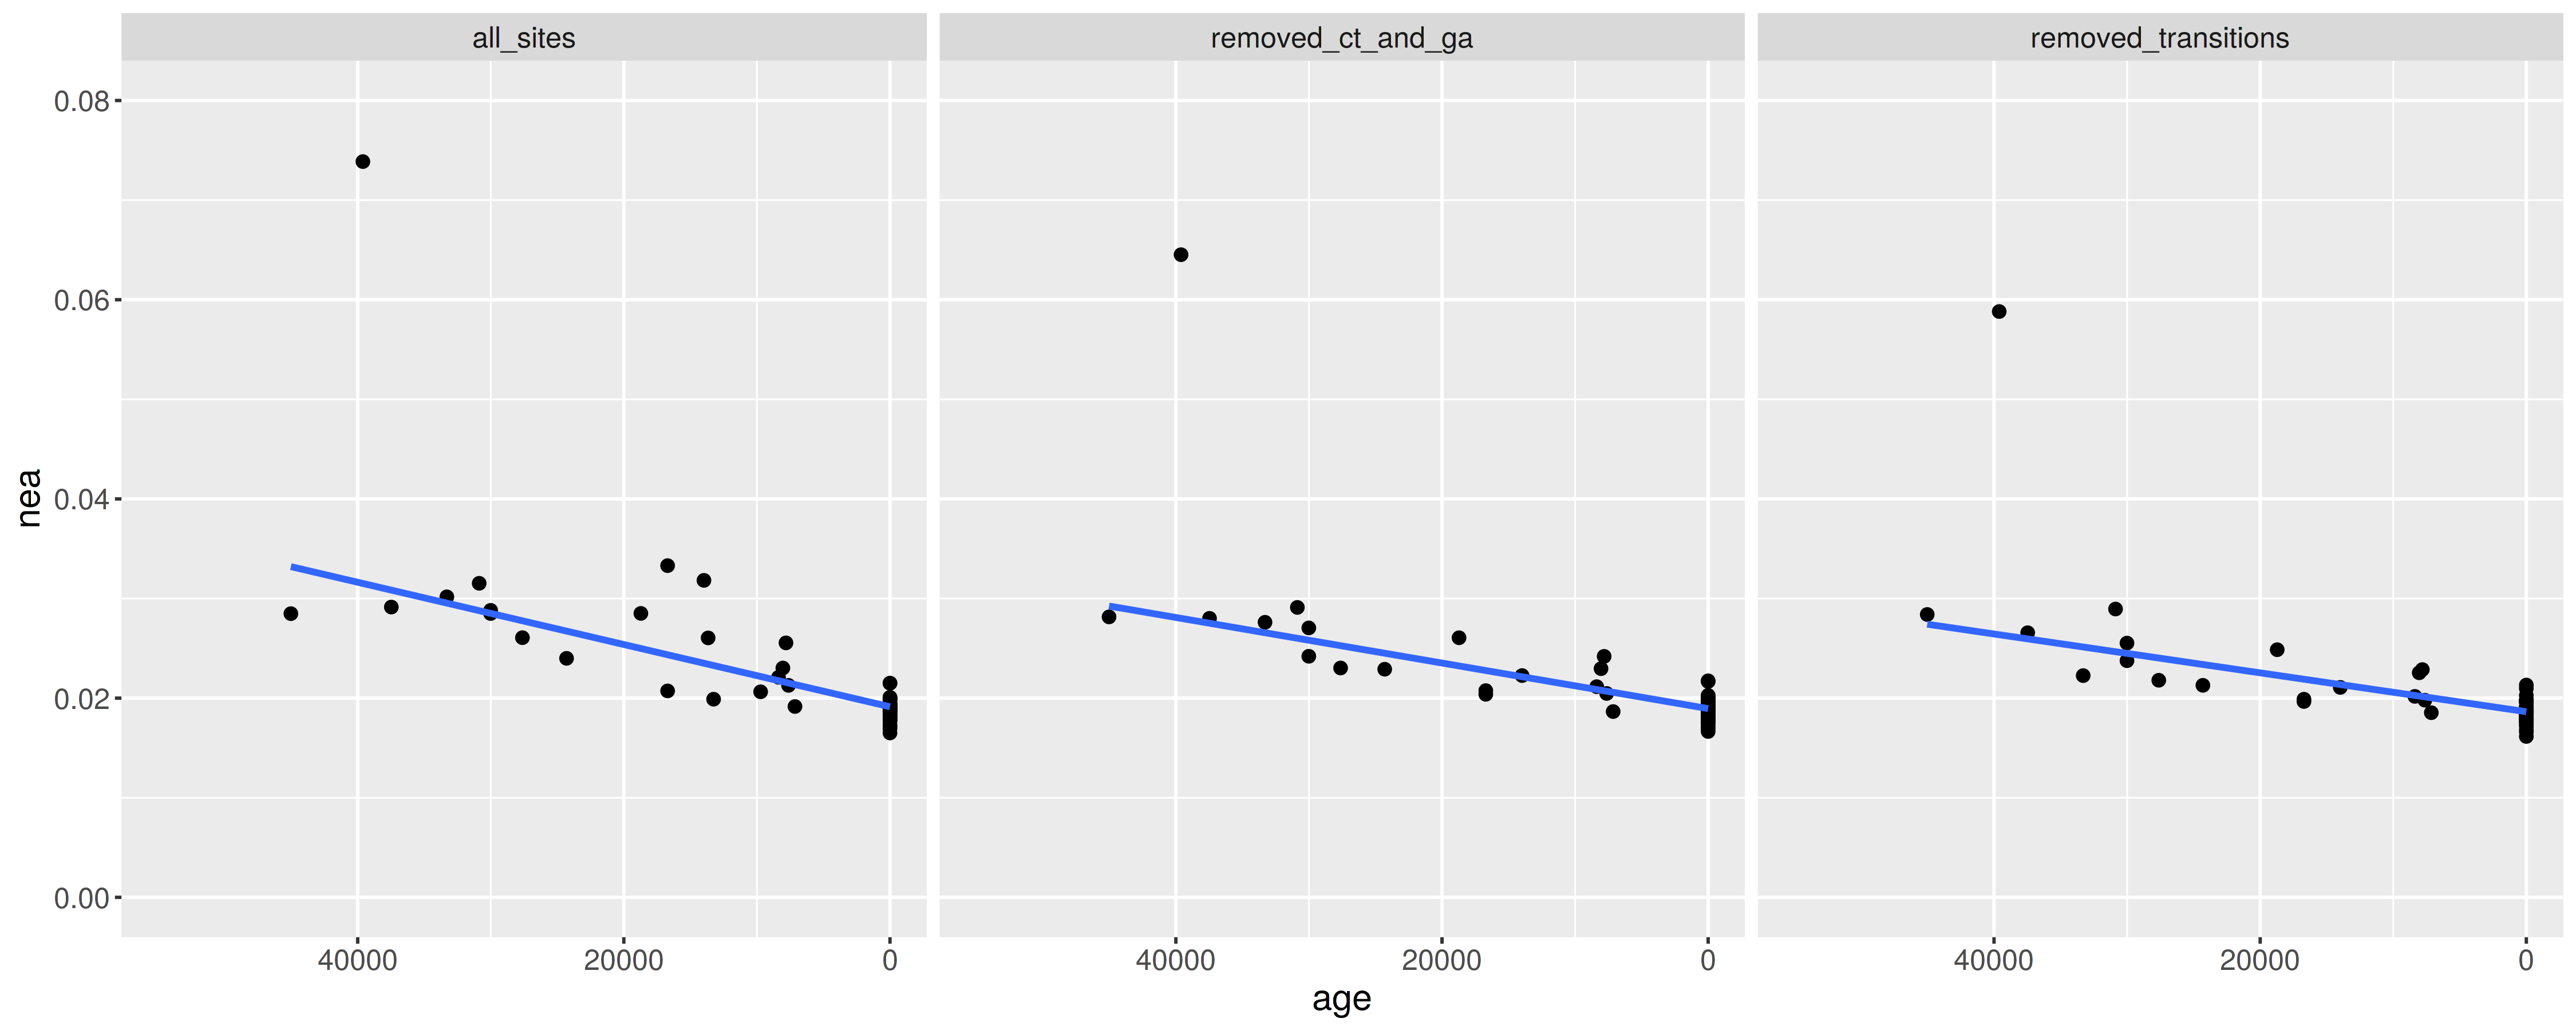

In [26]:
# SMBE
options(repr.plot.width=15, repr.plot.height=6)

filter(nea_ancestry,
       missing < missing_cutoff,
       (set == "all_sites" | !name %in% c("Satsurblia", "Kotias", "Bichon"))) %>%
{ ggplot(.) +
  geom_point(aes(age, nea), size=2) +
  lims(y=c(0, 0.08), x=c(55000, 0)) +
  geom_smooth(aes(age, nea), method="lm", se=FALSE, data=filter(., name != "Oase1")) +
  facet_grid(. ~ set) +
  theme(text=element_text(size=15)) }

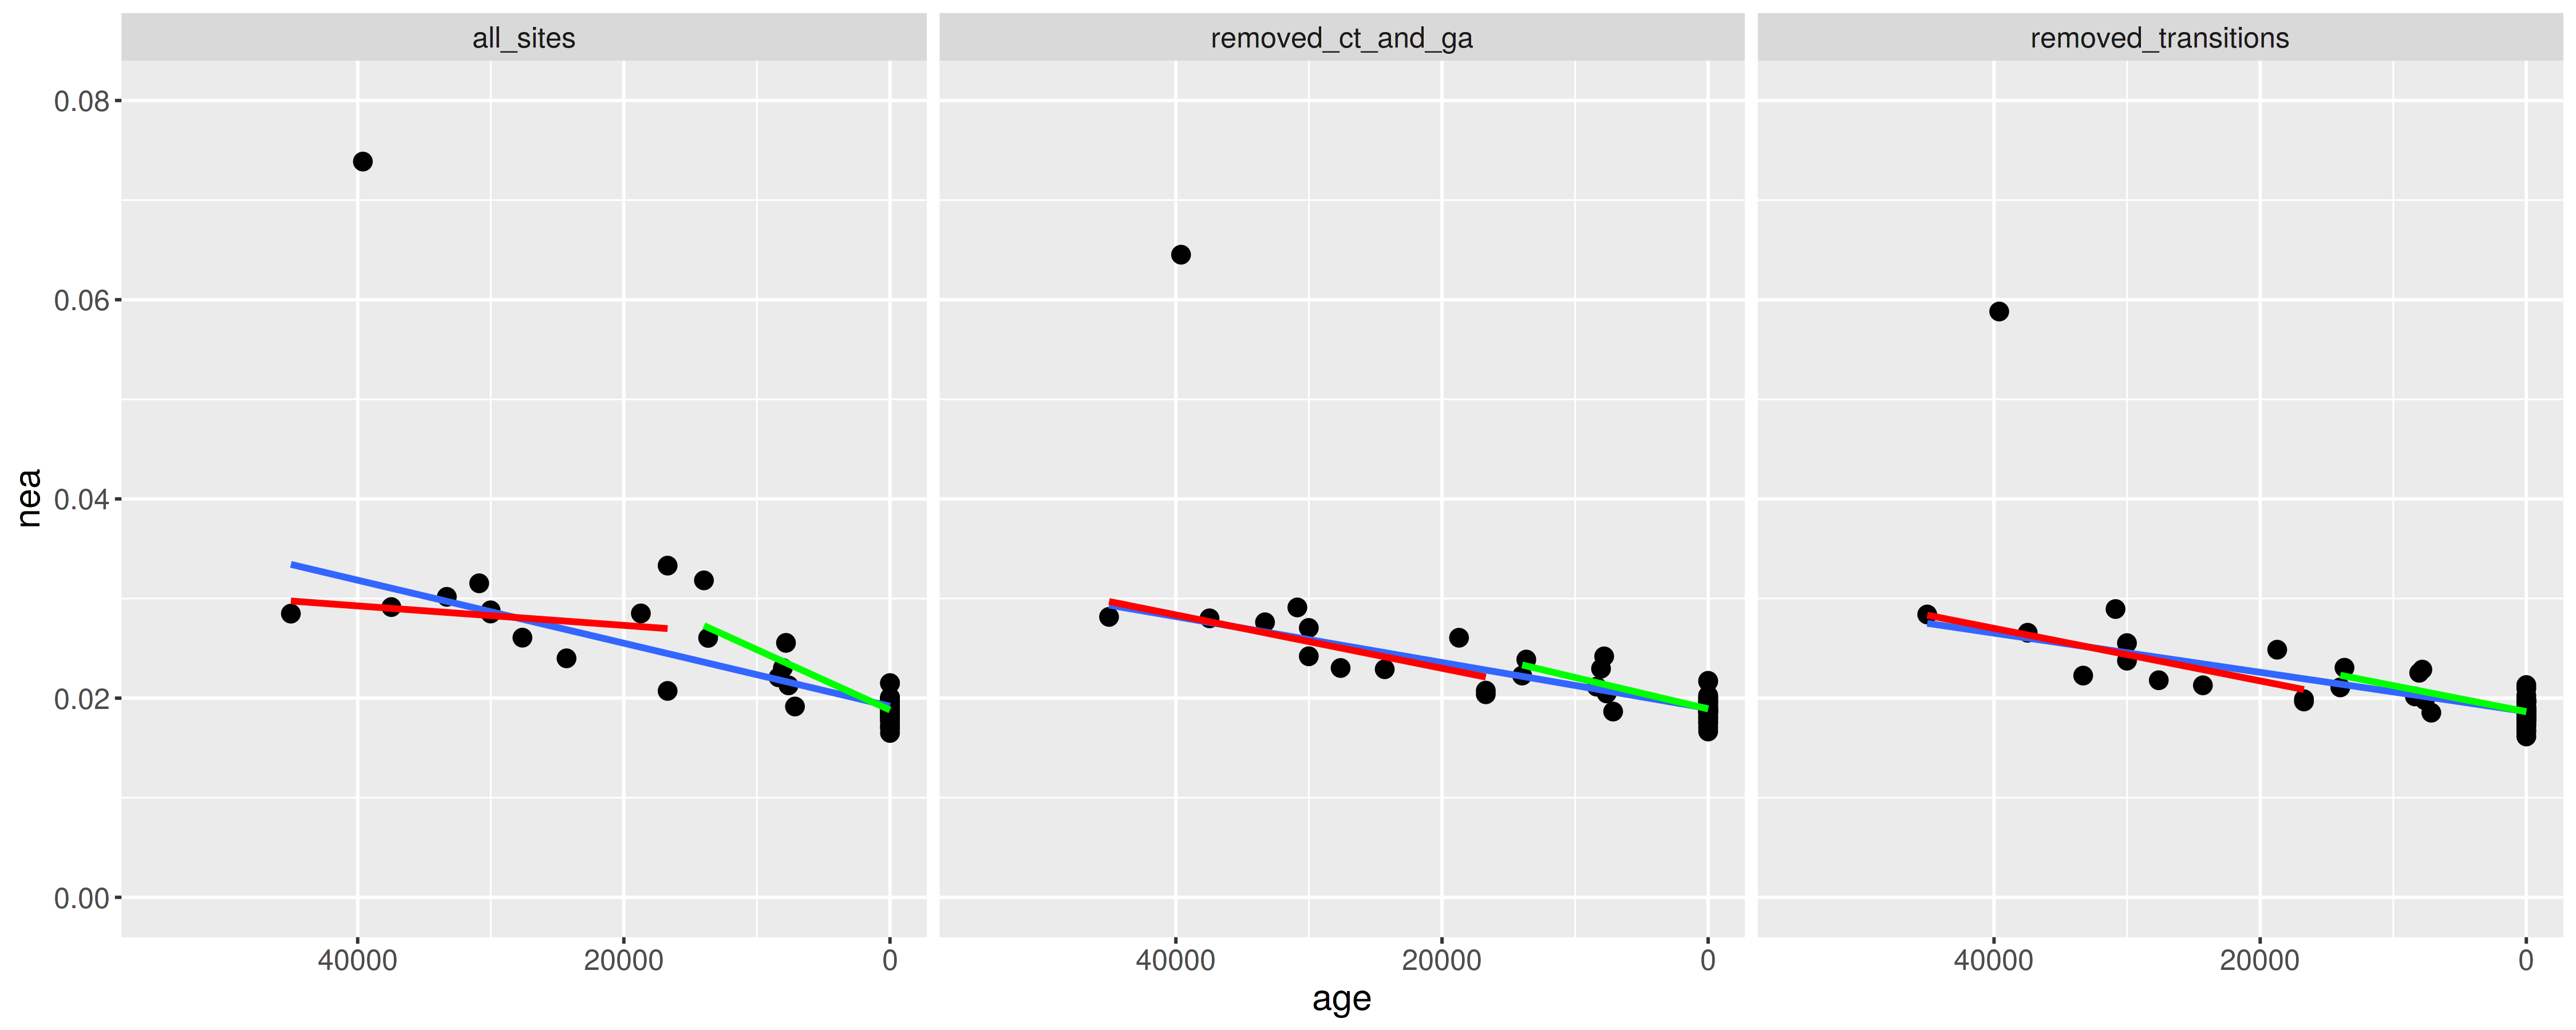

In [27]:
options(repr.plot.width=15, repr.plot.height=6)

filter(nea_ancestry,
       missing < missing_cutoff,
       (set == "all" | !name %in% c("Satsurblia", "Kotias"))) %>%
{ ggplot(.) +
  geom_point(aes(age, nea), size=3) +
  lims(y=c(0, 0.08), x=c(55000, 0)) +
  geom_smooth(aes(age, nea), method="lm", se=FALSE, data=filter(., name != "Oase1")) +
  geom_smooth(aes(age, nea), alpha=0.2, color="red", method="lm", se=FALSE, data=filter(., name != "Oase1", age > 14000)) +
  geom_smooth(aes(age, nea), alpha=0.2, color="green", method="lm", se=FALSE, data=filter(., name != "Oase1", age < 14000)) +

  facet_grid(. ~ set) +
  theme(text=element_text(size=15))
}